<a href="https://colab.research.google.com/github/mritogether/ESMRMB2024_Hardware_to_Map/blob/main/03_full_acquisition_simulations/notebooks/Talk2/ESMRMB_ET03_MRzero_to_the_rescue_More_complicated_sequences.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MRzero: More complicated sequences**

In this notebook, MRzero simulation is used to study a more complicatd sequence, DREAM, that involves both an FID signal component and a stimulated echo (STE) component and allows the mapping of the B0 offset, B1 and TxRx phase. The sequence file is written using pypulseq.


This notebook is adapted from Tim Baum's notebook which can be found in:

https://mrzero-core.readthedocs.io/en/v0.2.7/playground_mr0/mr0_DREAM_STE_seq.html#dream-ste-seq


**1. Install and import libraries**

In [46]:
!pip install pypulseq==1.4.2 &> /dev/null
!pip install MRzeroCore &> /dev/null
!wget https://github.com/MRsources/MRzero-Core/raw/main/documentation/playground_mr0/numerical_brain_cropped.mat &> /dev/null

In [47]:
import numpy as np
# newer numpy versions don't contain this, but pypulseq still relies on it
np.int = int
np.float = float
np.complex = complex

import MRzeroCore as mr0
import pypulseq as pp
import torch
import matplotlib.pyplot as plt
import os
from google.colab import output
import matplotlib.image as mpimg

plt.rcParams['figure.dpi'] = 100

**2. Prepare scanner**

In [48]:
system = pp.Opts(
    max_grad=80,
    grad_unit='mT/m',
    max_slew=200,
    slew_unit='T/m/s',
    rf_ringdown_time=30e-6,
    rf_dead_time=100e-6,
    adc_dead_time=20e-6,
    grad_raster_time=10e-6
)

**3. Acquisition conditions**

In [49]:
fov, slice_thickness = 200e-3, 8e-3#m
Nread, Nphase = 64, 64

**4. Construct sequence with pypulseq and save**

In [50]:
def aux_check_timing(seq):
  (ok,error_report,) = seq.check_timing()  # Check whether the timing of the sequence is correct
  if ok:
      print("Timing check passed successfully")
  else:
      print("Timing check failed. Error listing follows:")
      [print(e) for e in error_report]

def recon_fft(signal):
  kspace = torch.reshape((signal), (Nphase, Nread)).clone().t()
  kspace[:,0::2] = torch.flip(kspace[:,0::2],[0] )[:,:]
  spectrum = torch.fft.fftshift(kspace)
  space = torch.fft.fft2(spectrum)
  space = torch.fft.ifftshift(space)
  return space

**5. Overall EPI sequence generator and reconstruction**

In [51]:
# centric encoding
permvec=np.zeros((Nphase,),dtype=int)
permvec[0]=0
for i in range(1,int(Nphase//2+1)):
    permvec[i*2-1]=-i
    if i <Nphase/2:
      permvec[i*2]=i
permvec+=Nphase//2

def DREAM_generator_reconstruction(B0_factor = 0):

  obj_p_copy = phantom.build()

  # =====================
  #     Change phantom
  # =====================
  obj_p.B0 = obj_p_copy.B0 + B0_inhomogeneity*B0_factor

  # =====================
  #    Create sequence
  # =====================
  seq_DREAM = pp.Sequence()

  t0 = 5e-4 # smallest time interval [s] used in all events
  gx_read_amp = (2*Nread)/(fov*4*t0) # amplitude for G_m (gx_read) part of gx_ext
  gx_pre_amp = -7*gx_read_amp/2 # amplitude for G_m1 (gx_pre) part of gx_ext

  # Define rf events
  # STEAM rf pulses:
  rf1 = pp.make_block_pulse(flip_angle=55 * np.pi / 180, duration=t0, system=system)
  rf2 = pp.make_block_pulse(flip_angle=55 * np.pi / 180, phase_offset=180*np.pi/180, duration=t0, system=system)

  rf1.delay=0
  rf2.delay=0

  # FLASH readout pulse and slice selction gradients:
  rf3, gz3, gzr3 = pp.make_sinc_pulse(
      flip_angle=15 * np.pi/180,
      duration=2*t0,
      slice_thickness=slice_thickness,
      apodization=0.5,
      time_bw_product=4,
      system=system,
      return_gz=True
  )

  # Define other gradients and ADC events
  gx_ext = pp.make_extended_trapezoid(channel='x', amplitudes=np.array([0,gx_pre_amp,0,gx_read_amp,gx_read_amp,10*gx_read_amp,0]), times=np.array([0,1*t0,2*t0,3*t0,7*t0,8*t0,9*t0]), system=system)
  gx_m2 = pp.make_trapezoid(channel='x', area=-gx_read_amp*2*t0, duration=11*t0+2*gz3.fall_time-system.rf_ringdown_time, system=system)
  gx_spoil = pp.make_trapezoid(channel='x', area=6*gx_read_amp*t0, duration=1e-3, system=system)
  adc = pp.make_adc(num_samples=Nread*2, duration=4*t0, delay=3*t0, phase_offset=0*np.pi/180,system=system)

  #dummies
  dummies = 3

  #rf spoiling
  rf_phase = 0
  rf_inc = 0
  rf_spoiling_inc=84

  #centric reordering
  phase_enc__gradmoms = torch.arange(0,Nphase,1)-Nphase//2
  phase_enc__gradmoms=phase_enc__gradmoms[permvec]

  #STEAM block
  seq_DREAM.add_block(rf1)
  seq_DREAM.add_block(gx_m2)
  seq_DREAM.add_block(rf2)
  seq_DREAM.add_block(gx_spoil)

  #dummy block
  for i in range(0, dummies):
      #rf spoiling
      rf3.phase_offset = rf_phase / 180 * np.pi   # set current rf phase
      adc.phase_offset = rf_phase / 180 * np.pi  # follow with ADC
      rf_inc = divmod(rf_inc + rf_spoiling_inc, 360.0)[1]   # increase increment
      rf_phase = divmod(rf_phase + rf_inc, 360.0)[1]        # increment additional pahse
      #dummies
      seq_DREAM.add_block(rf3,gz3)
      seq_DREAM.add_block(gx_ext,gzr3)

  #readout block
  rf3.phase_offset = rf_phase / 180 * np.pi   # set current rf phase
  adc.phase_offset = rf_phase / 180 * np.pi  # follow with ADC
  rf_inc = divmod(rf_inc + rf_spoiling_inc, 360.0)[1]   # increase increment
  rf_phase = divmod(rf_phase + rf_inc, 360.0)[1]        # increment additional pahse

  seq_DREAM.add_block(rf3,gz3)
  seq_DREAM.add_block(gx_ext,gzr3,adc)

  for ii in range(1, Nphase):
      #rf spoiling
      rf3.phase_offset = rf_phase / 180.0 * np.pi   # set current rf phase
      adc.phase_offset = rf_phase / 180.0 * np.pi  # follow with ADC
      rf_inc = divmod(rf_inc + rf_spoiling_inc, 360.0)[1]   # increase increment
      rf_phase = divmod(rf_phase + rf_inc, 360.0)[1]        # increment additional pahse

      gy_amp = (2*phase_enc__gradmoms[ii])/(fov*2*t0) # set amplitude for y-gradients
      gy_ext = pp.make_extended_trapezoid(channel='y', amplitudes=np.array([0,gy_amp,0,0,-gy_amp,0]), times=np.array([0,1*t0,2*t0,7*t0,8*t0,9*t0]), system=system)
      seq_DREAM.add_block(rf3,gz3)
      seq_DREAM.add_block(gx_ext,gy_ext,gzr3,adc)

  seq_DREAM.write("DREAM.seq")

  # =====================
  #    Simulate signal
  # =====================
  seq0_DREAM = mr0.Sequence.import_file('DREAM.seq')
  graph_DREAM = mr0.compute_graph(seq0_DREAM, obj_p, 200, 1e-3)
  signal_DREAM = mr0.execute_graph(graph_DREAM, seq0_DREAM, obj_p)

  TE = 7*t0+gz3.fall_time

  seq_DREAM.plot()

  return seq_DREAM, signal_DREAM, TE


**6. Prepare digital phantom**

VoxelGridPhantom
size = tensor([0.2000, 0.2000, 0.0080])


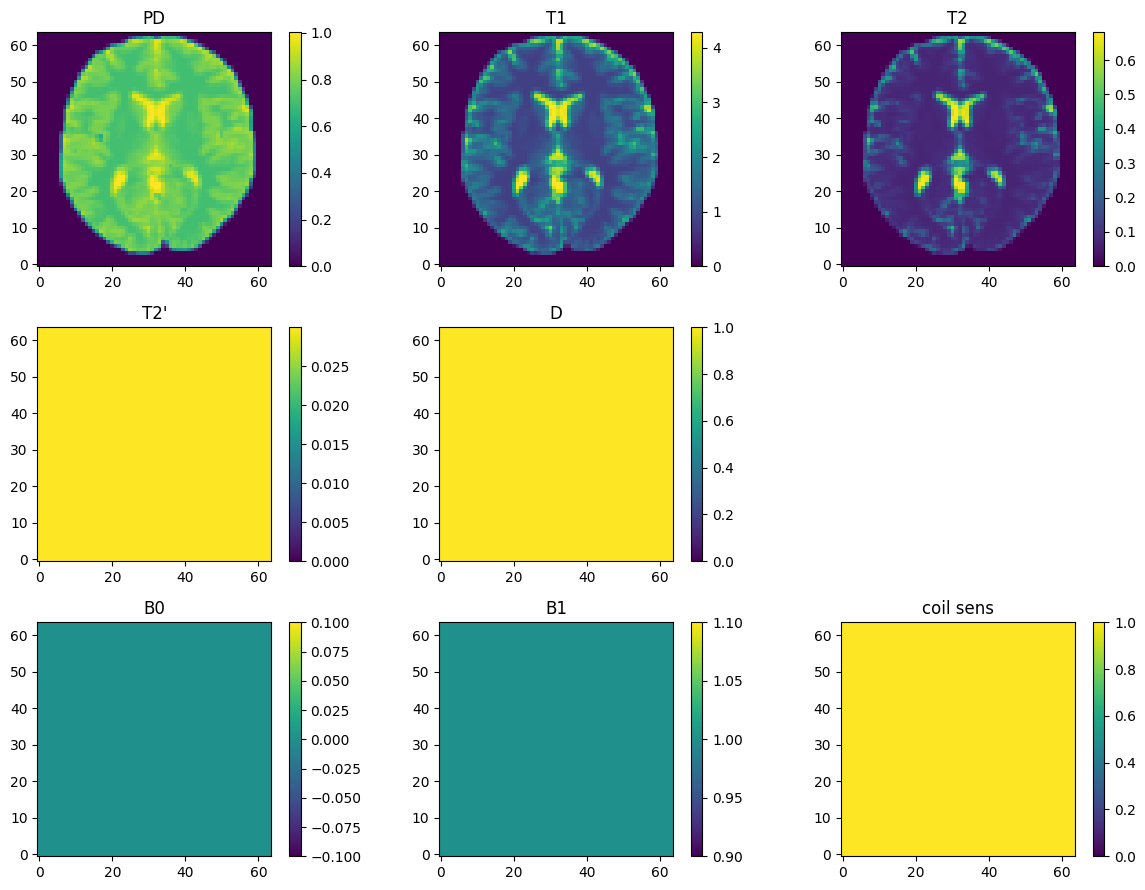

In [52]:
sz = [Nread, Nread]
phantom_inhomogeneity = mr0.VoxelGridPhantom.load_mat('numerical_brain_cropped.mat')
phantom = mr0.VoxelGridPhantom.load_mat('numerical_brain_cropped.mat')
phantom_inhomogeneity = phantom_inhomogeneity.interpolate(sz[0], sz[1], 1)
phantom = phantom.interpolate(sz[0], sz[1], 1)
# Convert Phantom into simulation data
phantom.B0[:] = 0
phantom.B1[:] = 1
obj_p = phantom.build()

obj_p_inhomogeneity = phantom_inhomogeneity.build()
B0_inhomogeneity = obj_p_inhomogeneity.B0
B1_inhomogeneity = obj_p_inhomogeneity.B1

phantom.plot()

**7. DREAM B0 mapping**

Calculating repetition 69 / 69 - done


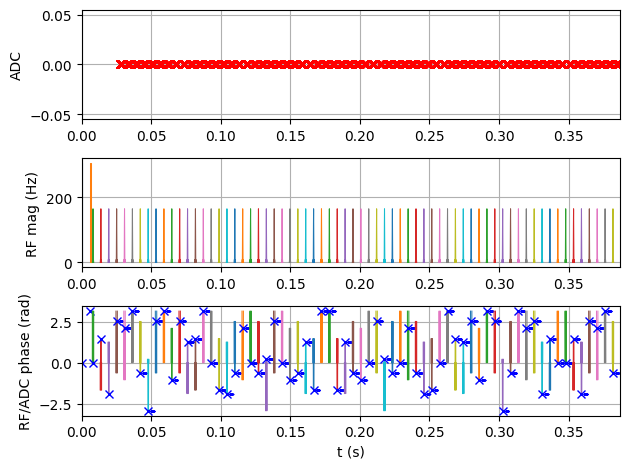

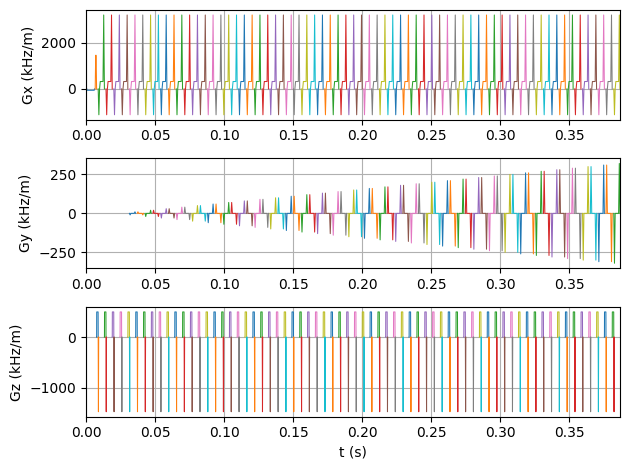

In [53]:
seq_DREAM, signal_DREAM, TE = DREAM_generator_reconstruction(B0_factor = 1)

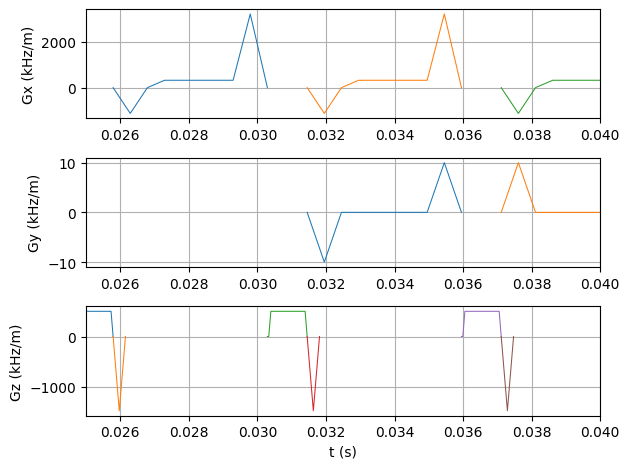

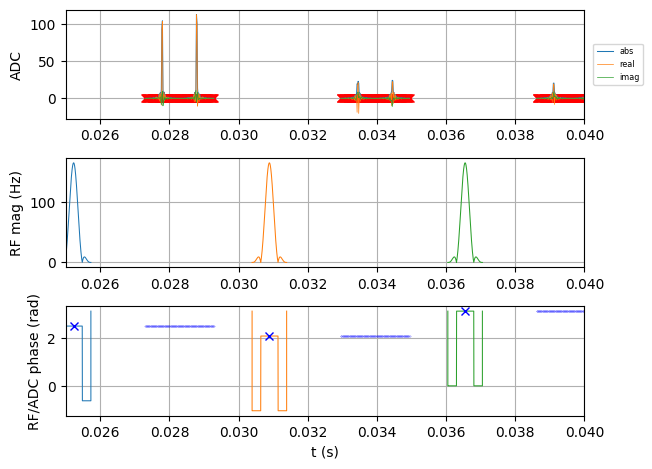

In [54]:
seq_DREAM.plot(time_range=(0.0250,0.040), plot_now = False)
mr0.util.insert_signal_plot(seq_DREAM, signal_DREAM.numpy())

(-0.5, 63.5, 63.5, -0.5)

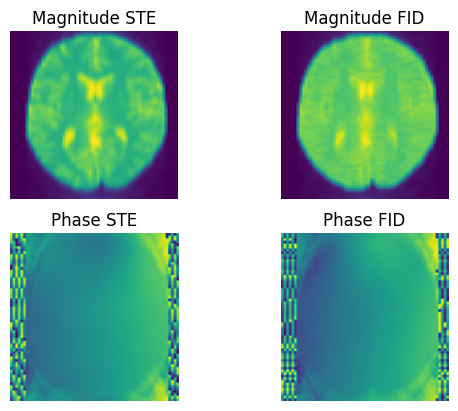

In [55]:
# divide signal into STE and FID
spectrum=torch.reshape((signal_DREAM),(Nphase,Nread*2)).clone().transpose(1,0)

# centric reordering
kspace_adc1=spectrum[0:Nread,:]
kspace_adc2=spectrum[Nread:,:]
ipermvec=np.arange(len(permvec))[np.argsort(permvec)]
kspace1=kspace_adc1[:,ipermvec]
kspace2=kspace_adc2[:,ipermvec]

# reconstruct STE and FID images
#recon of first kspace
space1 = torch.zeros_like(kspace1)
# fftshift
kspace1_1=torch.fft.fftshift(kspace1,0); kspace1_1=torch.fft.fftshift(kspace1_1,1)
#FFT
space1 = torch.fft.fft2(kspace1_1,dim=(0,1))
# fftshift
space1=torch.fft.ifftshift(space1,0); space1=torch.fft.ifftshift(space1,1)
space_STE = space1

#recon of first kspace
space2 = torch.zeros_like(kspace2)
# fftshift
kspace2_1=torch.fft.fftshift(kspace2,0); kspace2_1=torch.fft.fftshift(kspace2_1,1)
#FFT
space2 = torch.fft.fft2(kspace2_1,dim=(0,1))
# fftshift
space2=torch.fft.ifftshift(space2,0); space2=torch.fft.ifftshift(space2,1)
space_FID = space2

# plot
plt.figure()
plt.subplot(2,2,1)
plt.imshow(np.rot90(abs(space_STE)))
plt.title("Magnitude STE")
plt.axis("off")
plt.subplot(2,2,2)
plt.imshow(np.rot90(abs(space_FID)))
plt.title("Magnitude FID")
plt.axis("off")
plt.subplot(2,2,3)
plt.imshow(np.rot90(np.angle(space_STE)))
plt.title("Phase STE")
plt.axis("off")
plt.subplot(2,2,4)
plt.imshow(np.rot90(np.angle(space_FID)))
plt.title("Phase FID")
plt.axis("off")

Reconstruction of B0

In [56]:
# mask
mask = phantom.PD.clone()
mask[phantom.PD > 0] = 1
mask = mask[:,:,0].numpy()

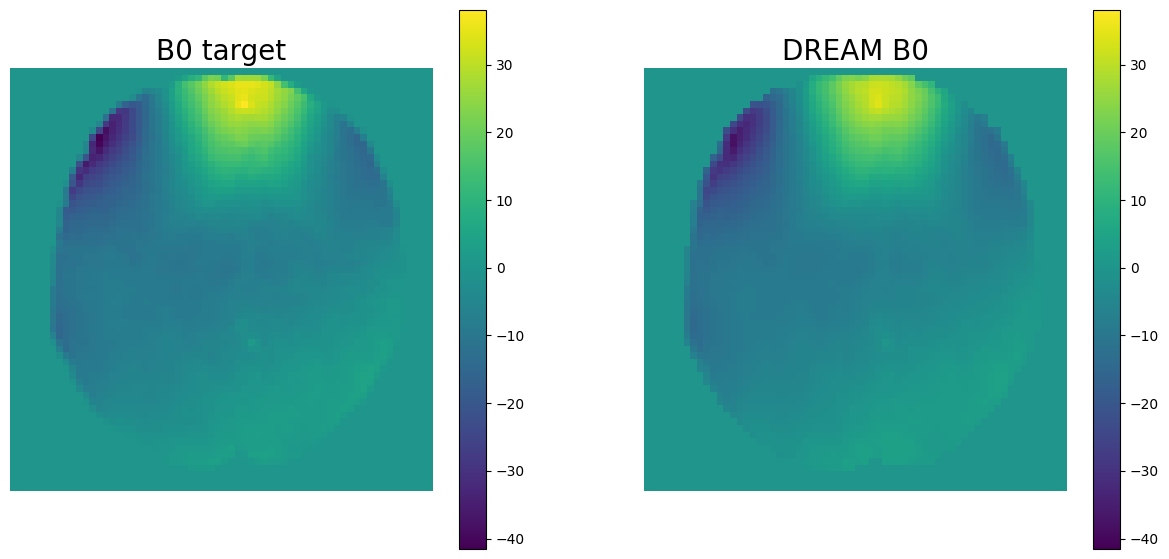

In [57]:
B0_rad = np.angle(space_FID*np.conjugate(space_STE)) / 2.
B0_Hz = B0_rad/(2*np.pi)*(1/(TE))
plt.figure(figsize = [15,7])
plt.subplot(1,2,1)
plt.imshow(np.rot90(phantom_inhomogeneity.B0[:,:,0]))
plt.title("B0 target", fontsize = 20)
plt.axis("off")
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(np.rot90(B0_Hz*mask), vmin = torch.min(phantom_inhomogeneity.B0[:,:,0]), vmax = torch.max(phantom_inhomogeneity.B0[:,:,0]))
plt.axis("off")
plt.title("DREAM B0", fontsize = 20)
plt.colorbar()